# Tutorial: Analyzing Edit Histories from Connectome Datasets

This notebook demonstrates the complete pipeline for:
1. Getting proofread neurons from MICrONS (mouse) dataset
2. Fetching edit histories for those neurons
3. Analyzing edit patterns (merge vs split, distributions)
4. Understanding the data structure

This is the core analysis for estimating computational proofreading costs.

In [13]:
import caveclient
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

## Step 1: Connect to MICrONS Dataset

The MICrONS dataset (mouse cortex) is publicly accessible via CAVEclient.

In [38]:
# Connect to the dataset
species = "fly"

if species == "mouse":
    client = caveclient.CAVEclient("minnie65_public")
elif species == "human":
    client = caveclient.CAVEclient("h01_c3_flat")#, server_address="https://global.brain-wire-test.org/")
elif species == "fly":
    client = caveclient.CAVEclient("flywire_fafb_public")
elif species == "zebrafish":
    client = caveclient.CAVEclient("fish1_full")

print(f"Connected to: {client.datastack_name}")
print(f"Server: {client.server_address}")

Connected to: flywire_fafb_public
Server: https://global.daf-apis.com


In [39]:
# List all available tables
print("Available tables in materialize:")
print("=" * 50)

# get_tables() - returns a list of table names
tables = client.materialize.get_tables()
print(f"Found {len(tables)} tables:\n")
for i, table in enumerate(tables, 1):
    print(f"  {i}. {table}")


Available tables in materialize:
Found 6 tables:

  1. hierarchical_neuron_annotations
  2. neuron_information_v2
  3. synapses_nt_v1
  4. nuclei_v1
  5. proofread_neurons
  6. fly_synapses_neuropil_v6


## Step 2: Get Proofread Neurons

For mouse, the `<proofread_table>` is "proofreading_status_and_strategy".
For human, the `<proofread_table>` is "proofreading_status_test".

There are different ways to query neurons:
<ul>
<li>**`query_table('<proofread_table>')`**: Officially proofread neurons</li>
<li>**`live_query('<proofread_table>', datetime.now())`**: Live version (Jeff's approach)</li>
</ul>

Let's explore both and understand the difference between `pt_root_id` and `valid_id` columns.

In [40]:
# Method 1: query_table
if species == "mouse":
    proofread_table = "proofreading_status_and_strategy"
elif species == "human":
    proofread_table = "proofreading_status_test"
elif species == "fly":
    proofread_table = "proofread_neurons"
elif species == "zebrafish":
    proofread_table = "somas"

print(f"Querying table: {proofread_table}")
table = client.materialize.query_table(proofread_table)

print(f"Total records: {len(table):,}")
print(f"\nColumns: {list(table.columns)}")
print(f"\nFirst few rows:")
table.head()

Querying table: proofread_neurons
Total records: 139,255

Columns: ['id', 'created', 'superceded_id', 'valid', 'pt_supervoxel_id', 'pt_root_id', 'pt_position']

First few rows:


,id,created,superceded_id,valid,pt_supervoxel_id,pt_root_id,pt_position
0,32414,2023-06-19 06:44:57.863498+00:00,<NA>,True,79871411195357919,720575940620919646,"[538210, 198330, 105601]"
1,1125,2023-06-19 06:43:33.633089+00:00,<NA>,True,77195887289571552,720575940611775973,"[381459, 106763, 171723]"
2,32416,2023-06-19 06:44:57.865882+00:00,<NA>,True,78955586729523534,720575940618135198,"[486480, 133840, 123110]"
3,32418,2023-06-19 06:44:57.867936+00:00,<NA>,True,79589661206805006,720575940624783287,"[523906, 181893, 72760]"
4,32419,2023-06-19 06:44:57.869497+00:00,<NA>,True,79589661207074646,720575940630755276,"[523523, 181919, 80829]"


In [41]:
# Check what columns contain neuron IDs
print("Checking pt_root_id vs valid_id...\n")

if 'pt_root_id' in table.columns:
    pt_root_ids = np.unique(table['pt_root_id'].values)
    print(f"Unique pt_root_id values: {len(pt_root_ids):,}")

if 'valid_id' in table.columns:
    valid_ids = np.unique(table['valid_id'].values)
    print(f"Unique valid_id values: {len(valid_ids):,}")

# Are they the same?
if 'pt_root_id' in table.columns and 'valid_id' in table.columns:
    same_count = (table['pt_root_id'] == table['valid_id']).sum()
    print(f"\nRows where pt_root_id == valid_id: {same_count} / {len(table)}")
    
    if same_count < len(table):
        print("\nThey're DIFFERENT! Let's see examples:")
        different = table[table['pt_root_id'] != table['valid_id']].head()
        print(different[['pt_root_id', 'valid_id']])

Checking pt_root_id vs valid_id...

Unique pt_root_id values: 139,255


In [42]:
# Method 2: live_query (Jeff's approach)
live_result = client.materialize.live_query(
    proofread_table,
    datetime.now()
)

# Get unique pt_root_ids (this is what Jeff uses)
neuron_ids = np.unique(np.asarray(live_result["pt_root_id"]))

print(f"Using live_query + pt_root_id:")
print(f"  Unique neurons: {len(neuron_ids):,}")

Using live_query + pt_root_id:
  Unique neurons: 139,255


## Step 3: Get Edit History for a Sample Neuron

Let's look at the edit history structure for a single neuron to understand what data we get.

In [47]:
np.random.randint(0, len(neuron_ids))

33593

In [49]:
# Pick a sample neuron
idx = np.random.randint(0, len(neuron_ids))
sample_neuron_id = neuron_ids[idx]

print(f"Getting edit history for neuron: {sample_neuron_id}")
print(f"Using client.chunkedgraph.get_tabular_change_log()...\n")

# Get edit history
edit_history = client.chunkedgraph.get_tabular_change_log(
    sample_neuron_id,
    filtered=True
)

# If it's a dict, convert to DataFrame (depending on caveclient version)
if isinstance(edit_history, dict):
    # If there's only one top-level key, extract its value (should be a DataFrame)
    if len(edit_history) == 1 and isinstance(list(edit_history.values())[0], pd.DataFrame):
        edit_history = list(edit_history.values())[0]
    else:
        # Otherwise, create a DataFrame from the dict (rare)
        edit_history = pd.DataFrame([edit_history])

print(f"Type: {type(edit_history)}")
print(f"Number of edits: {len(edit_history)}")
print(f"\nColumns: {list(edit_history.columns)}")

if len(edit_history) == 0:
    print("No edit history found for this neuron.")
else:
    print("\nFirst few edit rows:")
    display(edit_history.head())
    print("\nThe returned edit history has the following columns:")
    for col in edit_history.columns:
        print(f"  - {col}")

    # Show a concise summary to help visualize the structure
    print("\nExample edit operation (all columns):")
    display(edit_history.iloc[0:1].T)

Getting edit history for neuron: 720575940641548685
Using client.chunkedgraph.get_tabular_change_log()...

Type: <class 'pandas.core.frame.DataFrame'>
Number of edits: 3

Columns: ['operation_id', 'timestamp', 'user_id', 'before_root_ids', 'after_root_ids', 'is_merge', 'user_name', 'user_affiliation']

First few edit rows:


,operation_id,timestamp,user_id,before_root_ids,after_root_ids,is_merge,user_name,user_affiliation
0,1447088,1651726009450,1930,"[720575940382364308, 720575940620396817]",[720575940623178421],True,Darrel Jay Akiatan,"Mala Murthy Lab, Sebastian Seung Lab"
1,1581529,1655273311476,104,"[720575940614711407, 720575940623178421]",[720575940620595060],True,Ryan Willie,"Mala Murthy Lab, Sebastian Seung Lab"
2,1581530,1655273317526,104,"[720575940522569612, 720575940620595060]",[720575940641548685],True,Ryan Willie,"Mala Murthy Lab, Sebastian Seung Lab"



The returned edit history has the following columns:
  - operation_id
  - timestamp
  - user_id
  - before_root_ids
  - after_root_ids
  - is_merge
  - user_name
  - user_affiliation

Example edit operation (all columns):


,0
operation_id,1447088
timestamp,1651726009450
user_id,1930
before_root_ids,"[720575940382364308, 720575940620396817]"
after_root_ids,[720575940623178421]
is_merge,True
user_name,Darrel Jay Akiatan
user_affiliation,"Mala Murthy Lab, Sebastian Seung Lab"


### Understanding the Edit History Columns

Key columns:
- **`is_merge`**: True = merge operation (fixing split error), False = split operation (fixing merge error)
- **`before_root_ids`**: Segment IDs before the edit
- **`after_root_ids`**: Segment IDs after the edit  
- **`timestamp`**: When the edit was made
- **`operation_id`**: Unique ID for this edit

In [50]:
# Analyze this neuron's edit types
if 'is_merge' in edit_history.columns:
    merge_count = (edit_history['is_merge'] == True).sum()
    split_count = (edit_history['is_merge'] == False).sum()
    
    print(f"Neuron {sample_neuron_id} edit breakdown:")
    print(f"  Merge operations: {merge_count}")
    print(f"  Split operations: {split_count}")
    print(f"  Total: {len(edit_history)}")
else:
    print("Note: 'is_merge' column not found. May need to infer from before/after root IDs.")

Neuron 720575940641548685 edit breakdown:
  Merge operations: 3
  Split operations: 0
  Total: 3


## Step 4: Analyze Multiple Neurons

Now let's get edit histories for a sample of neurons to see the distribution.

In [ ]:
# Sample N random neurons
np.random.seed(42)
N = 100
sample_size = min(N, len(neuron_ids))
sampled_neurons = np.random.choice(neuron_ids, size=min(sample_size, len(neuron_ids)), replace=False)

print(f"Analyzing {len(sampled_neurons)} random neurons...")
print(f"This will take ~1 minute...\n")

def analyze_edit_history_tabular(edit_history):
    """
    Minimal version of analyze_edit_history from analysis/analyze_edit_distributions.py
    """
    # Handle None or empty
    if edit_history is None or (hasattr(edit_history, "__len__") and len(edit_history) == 0):
        return {
            "total_edits": 0,
            "merge_edits": 0,
            "split_edits": 0,
        }
    # Handle dict (sometimes CAVEclient gives {root_id: DataFrame})
    if isinstance(edit_history, dict):
        if len(edit_history) == 0:
            return {
                "total_edits": 0,
                "merge_edits": 0,
                "split_edits": 0,
            }
        # Get first value (should be DataFrame)
        edit_history = list(edit_history.values())[0]

    if hasattr(edit_history, "empty") and edit_history.empty:
        return {
            "total_edits": 0,
            "merge_edits": 0,
            "split_edits": 0,
        }

    # Count merge/split edits
    if 'is_merge' in edit_history.columns:
        merge_edits = (edit_history['is_merge'] == True).sum()
        split_edits = (edit_history['is_merge'] == False).sum()
    else:
        # Fallback: infer from before/after root IDs
        merge_edits = 0
        split_edits = 0
        for _, row in edit_history.iterrows():
            before_roots = row.get('before_root_ids', [])
            after_roots = row.get('after_root_ids', [])
            if isinstance(before_roots, str):
                # Convert string repr to list for FlyWire dict
                import ast
                before_roots = ast.literal_eval(before_roots)
            if isinstance(after_roots, str):
                import ast
                after_roots = ast.literal_eval(after_roots)
            if len(before_roots) > len(after_roots):
                merge_edits += 1
            else:
                split_edits += 1

    total_edits = len(edit_history)
    return {
        "total_edits": int(total_edits),
        "merge_edits": int(merge_edits),
        "split_edits": int(split_edits),
    }

# Collect statistics
results = []
for i, nid in enumerate(sampled_neurons):
    try:
        edit_hist = client.chunkedgraph.get_tabular_change_log(nid, filtered=True)
        stats = analyze_edit_history_tabular(edit_hist)
        stats['neuron_id'] = nid
        results.append(stats)
        if (i + 1) % (sample_size // 10) == 0:
            print(f"  Processed {i+1}/{len(sampled_neurons)}...")
    except Exception as e:
        print(f"  Error with neuron {nid}: {e}")
        continue

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(f"\n✓ Successfully analyzed {len(results_df)} neurons")

Analyzing 10 random neurons...
This will take ~1 minute...

  Processed 1/10...
  Processed 2/10...
  Processed 3/10...
  Processed 4/10...
  Processed 5/10...
  Processed 6/10...
  Processed 7/10...
  Processed 8/10...
  Processed 9/10...
  Processed 10/10...

✓ Successfully analyzed 10 neurons


## Step 5: Visualize Edit Distribution

In [52]:
# Summary statistics
print("Edit Statistics:")
print(f"  Mean edits per neuron: {results_df['total_edits'].mean():.2f}")
print(f"  Median edits per neuron: {results_df['total_edits'].median():.0f}")
print(f"  Max edits: {results_df['total_edits'].max()}")
print(f"  Min edits: {results_df['total_edits'].min()}")
print(f"\nTotal across sample:")
print(f"  Total edits: {results_df['total_edits'].sum()}")
print(f"  Merge operations: {results_df['merge_edits'].sum()}")
print(f"  Split operations: {results_df['split_edits'].sum()}")

Edit Statistics:
  Mean edits per neuron: 21.90
  Median edits per neuron: 14
  Max edits: 49
  Min edits: 6

Total across sample:
  Total edits: 219
  Merge operations: 167
  Split operations: 52


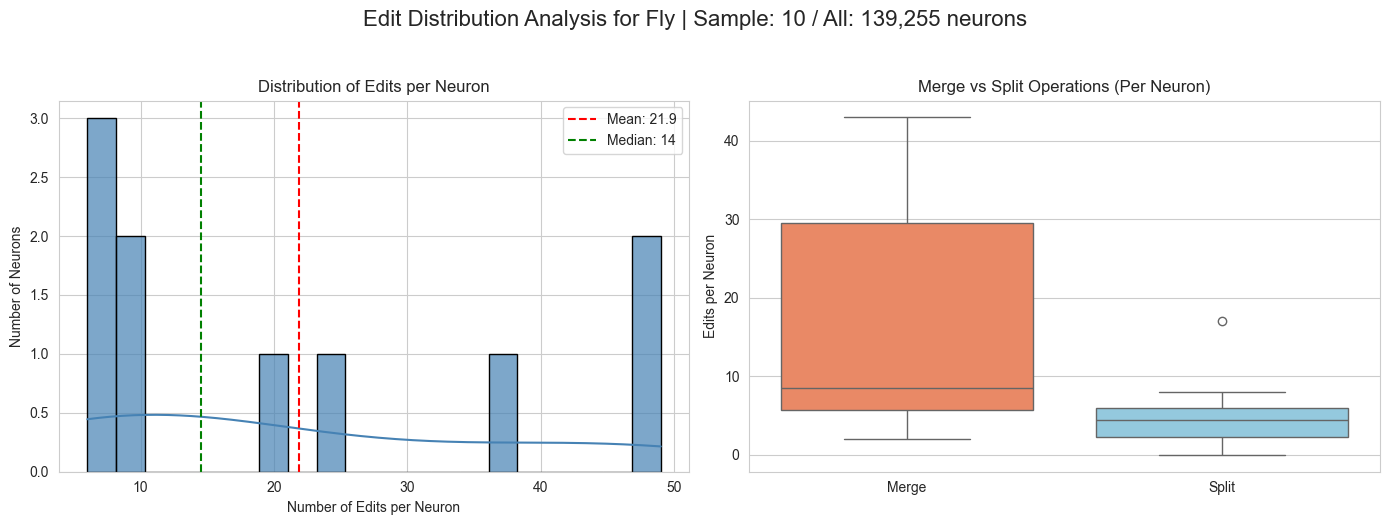

In [58]:
# If seaborn is not installed, you may need to run: !pip install seaborn
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Edit distribution with histogram and KDE fit
sns.histplot(
    results_df['total_edits'],
    bins=20,
    kde=True,
    color='steelblue',
    ax=axes[0],
    edgecolor='black',
    alpha=0.7
)
axes[0].axvline(results_df['total_edits'].mean(), color='red', linestyle='--',
                label=f'Mean: {results_df['total_edits'].mean():.1f}')
axes[0].axvline(results_df['total_edits'].median(), color='green', linestyle='--',
                label=f'Median: {results_df['total_edits'].median():.0f}')
axes[0].set_xlabel('Number of Edits per Neuron')
axes[0].set_ylabel('Number of Neurons')
axes[0].set_title('Distribution of Edits per Neuron')
axes[0].legend()

# Boxplot for Merge vs Split operations (per neuron)
merge_counts = results_df['merge_edits']
split_counts = results_df['split_edits']

sns.boxplot(
    data=[merge_counts, split_counts],
    ax=axes[1],
    palette=['coral', 'skyblue']
)
# Instead of set_xticklabels, use set_xticks and then set_xticklabels, or set_xticks directly.
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Merge', 'Split'])
axes[1].set_ylabel('Edits per Neuron')
axes[1].set_title('Merge vs Split Operations (Per Neuron)')

# Add suptitle with species, sample size, and full dataset size
try:
    suptitle_str = (
        f"Edit Distribution Analysis for {species.capitalize()} | "
        f"Sample: {len(results_df):,} / All: {len(neuron_ids):,} neurons"
    )
except Exception:
    suptitle_str = "Edit Distribution Analysis"

fig.suptitle(suptitle_str, fontsize=16, y=1.04)

plt.tight_layout()
plt.show()

## Step 6: Extrapolate to Full Dataset

Based on this sample, estimate costs for the full proofread dataset.

In [54]:
# Extrapolate
sample_size = len(results_df)
full_dataset_size = len(neuron_ids)
scaling_factor = full_dataset_size / sample_size

estimated_total_edits = int(results_df['total_edits'].sum() * scaling_factor)
estimated_merge_edits = int(results_df['merge_edits'].sum() * scaling_factor)
estimated_split_edits = int(results_df['split_edits'].sum() * scaling_factor)

print(f"Extrapolation to Full Dataset ({full_dataset_size:,} neurons):")
print(f"  Sample: {sample_size} neurons")
print(f"  Scaling factor: {scaling_factor:.1f}x")
print(f"\nEstimated totals:")
print(f"  Total edits: {estimated_total_edits:,}")
print(f"  Merge operations: {estimated_merge_edits:,}")
print(f"  Split operations: {estimated_split_edits:,}")
print(f"\nAverage per neuron: {results_df['total_edits'].mean():.2f} edits")

Extrapolation to Full Dataset (139,255 neurons):
  Sample: 10 neurons
  Scaling factor: 13925.5x

Estimated totals:
  Total edits: 3,049,684
  Merge operations: 2,325,558
  Split operations: 724,126

Average per neuron: 21.90 edits


## Next Steps

To calculate GPU costs:
1. Multiply edit counts by computational cost per edit type
2. Cost per edit depends on:
   - Model: Qwen 32B on 2x H100 GPUs
   - Inference time per edit
   - GPU utilization

Formula:
```
Total Cost = (merge_edits × cost_per_merge) + (split_edits × cost_per_split)
```

This data provides the edit counts needed for that calculation!